In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [3]:
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)
test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

In [4]:
# day를 year로 변경해주는 함수
def days_to_age(x):
    return (x*-1)/365

In [5]:
# 마이너스 변환
def minus(x):
    return x * -1

# 추가 변수 생성하기

In [6]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e_r_c'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) + "_" + data['reality'] + "_" + data['car'] 
    
    return data

In [7]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [8]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log)

    # DAYS_EMPLOYED 변수 전처리
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
    # day를 year로 변환
    data.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
    
    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 income 데이터 전처리
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
    
    # 가족수와 자녀수 sum
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수로 나눈 비율
    data['INCOME_FAM_SUM_RATIO'] = data['income_total']/data['family_size']
    
    # 일을하게 된 시점 변수 추가
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['INCOME_before_EMPLOYED_RATIO'] = data['income_total']/data['before_EMPLOYED']
    return data 

In [9]:
train = numeric_process(train)
test = numeric_process(test)

In [10]:
def occype_process(data):
    
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    #data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    
    return data


In [11]:
train = occype_process(train)
test = occype_process(test)

In [12]:
#minus 변경하고
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    #data[variable] =- data[variable]
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]

In [13]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음

make_bin(train, 'DAYS_BIRTH', n=10)
# make_bin(train, 'income_total_log', n=25)
# make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
make_bin(test, 'DAYS_BIRTH', n=10)
# make_bin(test, 'income_total_log', n=25)
# make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

In [14]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'family_size', 'child_num'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'family_size', 'child_num'], axis=1)

In [16]:
train.shape, test.shape

((26457, 30), (10000, 29))

In [17]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

# AUTOML

In [1]:
train

NameError: name 'train' is not defined

In [63]:
a = []
a.append(train.columns[7])
a.append(train.columns[12])
a.extend(list(train.columns[17:27]))
a

for i in a:
    train[i]= train[i].astype('float32')

ValueError: could not convert string to float: '0_0_0_N_N'

In [21]:
train = train.astype('float32')

ValueError: could not convert string to float: 'F'

In [16]:
from pycaret.classification import *
clf = setup(data = train, target = 'credit') 

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:38:04
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
gender,Categorical
car,Categorical
reality,Categorical
income_type,Categorical
edu_type,Categorical
family_type,Categorical
house_type,Categorical
DAYS_BIRTH,Numeric
work_phone,Categorical
phone,Categorical


MemoryError: Unable to allocate 9.35 GiB for an array with shape (2, 627753025) and data type object

In [ ]:
from sklearn.metrics import log_loss
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)


In [ ]:
best_5 = compare_models(sort = 'F1', n_select = 5)

In [ ]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended)

In [ ]:
final_model = finalize_model(blended)

In [ ]:
predictions = predict_model(final_model, data = test)

In [17]:
train.head()

,gender,car,reality,income_type,edu_type,family_type,house_type,DAYS_BIRTH,work_phone,phone,...,DAYS_EMPLOYED_log,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,INCOME_BIRTH_RATIO,diff_fam_child,FAM_CHILD_SUM,INCOME_FAM_SUM_RATIO,before_EMPLOYED,INCOME_before_EMPLOYED_RATIO,DAYS_BIRTH_bin
0,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,38.079,0,0,...,8.457,0.339,1.570,0.532,2.0,2.0,10.125,25.178,0.804,0
1,F,N,Y,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.178,0,0,...,7.340,0.135,5.866,0.794,2.0,4.0,8.250,26.959,0.918,1
2,M,Y,Y,Working,Higher education,Married,House / apartment,52.293,0,1,...,8.397,0.232,3.704,0.861,2.0,2.0,22.500,40.145,1.121,2
3,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,41.337,0,1,...,7.646,0.139,3.533,0.490,2.0,2.0,10.125,35.605,0.569,3
4,F,Y,Y,State servant,Higher education,Married,House / apartment,41.197,0,0,...,7.653,0.140,2.731,0.382,2.0,2.0,7.875,35.430,0.445,3


In [36]:
train.columns[2]

'reality'

In [16]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26457 non-null  object 
 1   car                           26457 non-null  object 
 2   reality                       26457 non-null  object 
 3   income_type                   26457 non-null  object 
 4   edu_type                      26457 non-null  object 
 5   family_type                   26457 non-null  object 
 6   house_type                    26457 non-null  object 
 7   DAYS_BIRTH                    26457 non-null  float64
 8   work_phone                    26457 non-null  int64  
 9   phone                         26457 non-null  int64  
 10  email                         26457 non-null  int64  
 11  occyp_type                    26457 non-null  object 
 12  begin_month                   26457 non-null  float64
 13  p

# 모델 학습

In [ ]:
cat_models={}

# object형 변수는 cat_features에 추가
cat_features = [0,1,2,3,4,5,6,11,13,14,15,16]
random_seed = [1042]

def run_kfold():
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=seed, learning_rate =0.04, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    
my_submission = run_kfold()

====================================1============================================
0:	learn: 1.0753798	test: 1.0753798	test1: 1.0756978	best: 1.0756978 (0)	total: 153ms	remaining: 7m 39s
100:	learn: 0.7149364	test: 0.5138763	test1: 0.6911657	best: 0.6911657 (100)	total: 11.1s	remaining: 5m 17s
200:	learn: 0.6990449	test: 0.4874802	test1: 0.6844527	best: 0.6844527 (200)	total: 23.7s	remaining: 5m 30s
300:	learn: 0.6850011	test: 0.4724561	test1: 0.6817504	best: 0.6817267 (298)	total: 37.4s	remaining: 5m 35s
400:	learn: 0.6693490	test: 0.4642606	test1: 0.6803594	best: 0.6802998 (399)	total: 50.9s	remaining: 5m 29s
500:	learn: 0.6539267	test: 0.4593475	test1: 0.6796164	best: 0.6792587 (474)	total: 1m 4s	remaining: 5m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6792586547
bestIteration = 474

Shrink model to first 475 iterations.
FOLD 1 : logloss:0.6792586546591312


====================================2============================================
0:	learn: 1.0754

0:	learn: 1.0756621	test: 1.0754057	test1: 1.0753693	best: 1.0753693 (0)	total: 143ms	remaining: 7m 8s


In [23]:
cat_features = [0,1,2,3,4,5,6,11,13,14,15,16]
cat = CatBoostClassifier(n_estimators=500, max_depth=8, random_seed=2, learning_rate =0.04, bootstrap_type ='Bernoulli')
cat.fit(train_x, train_y,cat_features=cat_features,verbose=100)
test_predictions = cat.predict_proba(test)

0:	learn: 1.0754979	total: 68.5ms	remaining: 34.2s
100:	learn: 0.7124827	total: 9.06s	remaining: 35.8s
200:	learn: 0.6962646	total: 19.7s	remaining: 29.4s
300:	learn: 0.6823573	total: 30.6s	remaining: 20.3s
400:	learn: 0.6676639	total: 41.3s	remaining: 10.2s
499:	learn: 0.6544544	total: 52.1s	remaining: 0us


In [25]:
test_predictions 

array([[0.13768141, 0.15365434, 0.70866425],
       [0.33046821, 0.27046581, 0.39906598],
       [0.0380291 , 0.0695126 , 0.8924583 ],
       ...,
       [0.04654655, 0.11433793, 0.83911552],
       [0.15205977, 0.29822079, 0.54971944],
       [0.06609197, 0.46567345, 0.46823458]])

# Feature_Importance_Plot

In [187]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


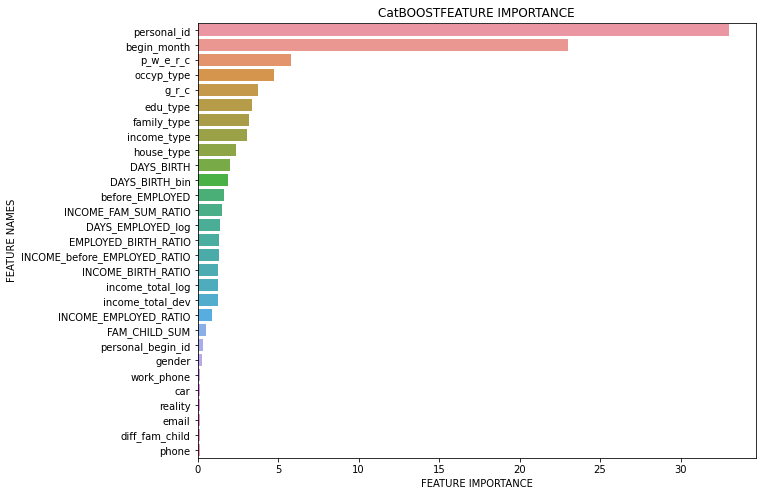

In [188]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# 결과 확인 및 제출 파일 생성

In [189]:
my_submission

array([[0.13122964, 0.16462105, 0.70414932],
       [0.32423821, 0.24229416, 0.43346763],
       [0.04554284, 0.07627338, 0.87818377],
       ...,
       [0.04898638, 0.12141395, 0.82959967],
       [0.14836392, 0.31489328, 0.53674279],
       [0.07238306, 0.41835301, 0.50926393]])

In [26]:
test_predictions 

array([[0.13768141, 0.15365434, 0.70866425],
       [0.33046821, 0.27046581, 0.39906598],
       [0.0380291 , 0.0695126 , 0.8924583 ],
       ...,
       [0.04654655, 0.11433793, 0.83911552],
       [0.15205977, 0.29822079, 0.54971944],
       [0.06609197, 0.46567345, 0.46823458]])

In [27]:
submission=pd.read_csv('./sample_submission.csv')
submission.loc[:,1:]=test_predictions 
submission

,index,0,1,2
0,26457,0.137681,0.153654,0.708664
1,26458,0.330468,0.270466,0.399066
2,26459,0.038029,0.069513,0.892458
3,26460,0.051003,0.082153,0.866845
4,26461,0.063112,0.225663,0.711225
...,...,...,...,...
9995,36452,0.066717,0.229289,0.703994
9996,36453,0.130368,0.431912,0.437720
9997,36454,0.046547,0.114338,0.839116
9998,36455,0.152060,0.298221,0.549719


In [28]:
submission.to_csv('./finalize.csv', index=False) # 0.7272812144

In [29]:
submission.head(20)

,index,0,1,2
0,26457,0.137681,0.153654,0.708664
1,26458,0.330468,0.270466,0.399066
2,26459,0.038029,0.069513,0.892458
3,26460,0.051003,0.082153,0.866845
4,26461,0.063112,0.225663,0.711225
5,26462,0.060123,0.138082,0.801795
6,26463,0.600578,0.372729,0.026693
7,26464,0.048152,0.078203,0.873645
8,26465,0.058365,0.085842,0.855793
9,26466,0.062213,0.268224,0.669563
